In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
from scipy.sparse import csr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

In [2]:
root_name = 'Fig_3_4_Algorithm_Variations_Result_2'

In [ ]:
result = unpack_sparse_cross_compare_results(root_name,
                                             results_subdir='PNAS_Paper',
                                             use_sparse_matrix=True)

In [3]:
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs,},
                                                   multi_job_comp=True,
                                                   use_sparse_matrix=False,
                                                   project_name='learning-dynamics',
                                                   results_subdir='PNAS_Paper',
                                                   username='om2382')

In [4]:
root_name = 'Fig_3_4_Algorithm_Variations_Result_2'
results_dir = '/home/om2382/learning-dynamics/results/PNAS_Paper'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

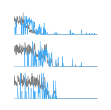

In [5]:
### --- Plot individual example trajectories --- ###
cm = 2.54
fig, ax = plt.subplots(3, 1, figsize=(3/cm, 3/cm))
signal_keys_ordered = [k for k in signal_dicts.keys()]
for i_ax, i_analysis in enumerate([16, 0, 8]):
    key = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[key]['indices']
    ax[i_ax].plot(signal_dicts[key]['test_loss'], linewidth=0.3, color='#7F7F7F')
    ax[i_ax].plot(signal_dicts[key]['aligned_graph_distances'], linewidth=0.3, color='#3FA9F5')
    ax[i_ax].axis('off')
    ax[i_ax].set_ylim([-0.05, 1])
#fig.savefig('figs/example_3_d_dyn_loss_traces.pdf')

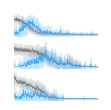

In [6]:
### --- Group traces by algorithm and seed --- ###

algs = ['RFLO', 'BPTT', 'DNI']
loss_traces = np.zeros((3, 500, 8))
d_dyn_traces = np.zeros((3, 499, 8))
for i_key, key in enumerate(signal_dicts):
    i_alg = algs.index(key.split('learn_alg=')[-1])
    i_seed = int(key.split('seed=')[-1][0])
    loss = signal_dicts[key]['test_loss']
    d_dyn = signal_dicts[key]['aligned_graph_distances']
    loss_traces[i_alg,:,i_seed] = loss
    d_dyn_traces[i_alg,:,i_seed] = d_dyn

### --- Plot averages --- ###

cm = 1/2.54
fig, ax = plt.subplots(3, 1, figsize=(3*cm, 3*cm))
for i_ax in range(3):
    loss_mu = loss_traces[i_ax].mean(-1)
    loss_sem = loss_traces[i_ax].std(-1)/np.sqrt(1)
    d_dyn_mu = d_dyn_traces[i_ax].mean(-1)
    d_dyn_sem = d_dyn_traces[i_ax].std(-1)/np.sqrt(1)
    ax[i_ax].plot(loss_mu, color='#7F7F7F', linewidth=0.3)
    ax[i_ax].fill_between(list(range(len(loss_mu))),
                          loss_mu-loss_sem, loss_mu+loss_sem, color='#7F7F7F', alpha=0.2)
    ax[i_ax].plot(d_dyn_mu, color='#3FA9F5', linewidth=0.3)
    ax[i_ax].fill_between(list(range(len(d_dyn_mu))),
                          d_dyn_mu-d_dyn_sem, d_dyn_mu+d_dyn_sem, color='#3FA9F5', alpha=0.2)
    ax[i_ax].set_ylim([-0.05, 1])
    ax[i_ax].axis('off')
#fig.savefig('figs/alg_averages_std.pdf')

In [7]:
### --- Correlation with d_dyn and dLoss --- ###

from scipy.stats import pearsonr, spearmanr

filters = [1, 3, 10, 30, 50, 100]
coefs = np.zeros((len(filters), len(filters)))
p_values = np.zeros_like(coefs)
alg = 'DNI'
i_alg = algs.index(alg)
dloss_traces = loss_traces[:,1:,:] - loss_traces[:,:-1,:]
for i, t_dyn_filter in enumerate(filters):
    for j, t_loss_filter in enumerate(filters):
        filtered_dloss = uniform_filter1d(dloss_traces[i_alg], axis=0, size=t_loss_filter)
        filtered_d_dyn = uniform_filter1d(d_dyn_traces[i_alg], axis=0, size=t_dyn_filter)
        ccoef = pearsonr(filtered_dloss.flatten(), filtered_d_dyn.flatten())
        coefs[i,j] = ccoef.statistic
        p_values[i,j] = ccoef.pvalue

-204.7274003641552
-23.926547523942023
-33.23027649557839


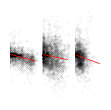

In [8]:
from sklearn.linear_model import LinearRegression
cm = 1/2.54
fig, ax = plt.subplots(1, 3, figsize=(3*cm, 3*cm))
for i_alg in range(3):
    filtered_dloss = uniform_filter1d(dloss_traces[i_alg], axis=0, size=20)
    filtered_d_dyn = uniform_filter1d(d_dyn_traces[i_alg], axis=0, size=20)
    model = LinearRegression()
    dloss = filtered_dloss.flatten()
    ddyn = filtered_d_dyn.flatten()
    model.fit(ddyn.reshape(-1, 1), dloss)
    ax[i_alg].plot(ddyn, dloss, '.', alpha=0.2, color='k', markersize=0.3)
    x = np.arange(0, 0.7, 0.1)
    ax[i_alg].plot(x, x*model.coef_ + model.intercept_, color='r', linewidth=0.5)
    ax[i_alg].set_ylim([-0.05, 0.05])
    ax[i_alg].set_xlim([-0.01, 0.65])
    ax[i_alg].axis('off')
    #ax[i_alg].set_title('log(p) = {:2f}'.format(np.log10(pearsonr(ddyn, dloss).pvalue)))
    print(np.log10(pearsonr(ddyn, dloss).pvalue))
#fig.savefig('figs/dloss_ddyn_corr_no_axis.png', dpi=500)

-33.23027649557839
-23.926547523942023
-204.7274003641552


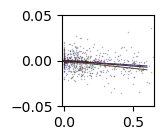

In [19]:
from sklearn.linear_model import LinearRegression
cm = 1/2.54
fig = plt.figure(figsize=(3*cm, 3*cm))
alg_colors = ['#4a1b1f', '#2e3192', '#404c24']
for i_alg in [2, 1, 0]:
    filtered_dloss = uniform_filter1d(dloss_traces[i_alg], axis=0, size=20)
    filtered_d_dyn = uniform_filter1d(d_dyn_traces[i_alg], axis=0, size=20)
    dloss = filtered_dloss.flatten()
    ddyn = filtered_d_dyn.flatten()
    plt.plot(ddyn[::10], dloss[::10], 'x', alpha=0.4, color=alg_colors[i_alg], markersize=0.4)
for i_alg in [2, 1, 0]:
    filtered_dloss = uniform_filter1d(dloss_traces[i_alg], axis=0, size=20)
    filtered_d_dyn = uniform_filter1d(d_dyn_traces[i_alg], axis=0, size=20)
    model = LinearRegression()
    dloss = filtered_dloss.flatten()
    ddyn = filtered_d_dyn.flatten()
    model.fit(ddyn.reshape(-1, 1), dloss)
    x = np.arange(0, 0.7, 0.1)
    print(np.log10(pearsonr(ddyn, dloss).pvalue))
    plt.plot(x, x*model.coef_ + model.intercept_, color=alg_colors[i_alg], linewidth=0.7)
plt.ylim([-0.05, 0.05])
plt.xlim([-0.01, 0.65])
#plt.axis('off')
    #ax[i_alg].set_title('log(p) = {:2f}'.format(np.log10(pearsonr(ddyn, dloss).pvalue)))

fig.savefig('figs/dloss_ddyn_corr_new_colors_3.pdf')

In [17]:
### --- ASSIGN TIME POINTS TO STAGES --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_3_stages(loss, d_top,
                                                                            performance_criterion=0.05,
                                                                            topological_criterion=0.1,
                                                                            loss_window=1,
                                                                            topological_window=20)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

In [30]:
### --- ASSIGN TIME POINTS TO 4 STAGES --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=1,
                                                                          topological_window=20)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

In [27]:
### --- RELATIVE STAGE OCCUPANCY

relative_stage_time = np.zeros((3, 8, 3))
algs = ['RFLO', 'BPTT', 'DNI']
for key in signal_keys_ordered:
    i_alg = algs.index(key.split('learn_alg=')[-1])
    i_seed = int(key.split('seed=')[-1][0])
    for k in range(3):
        total_time = len(np.where(dict_of_stage_assignments[key]!=4)[0])
        relative_stage_time[i_alg, i_seed, k] = len(np.where(dict_of_stage_assignments[key]==k+1)[0])/total_time

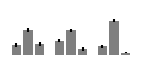

In [61]:
cm = 1/2.54
fig, ax = plt.subplots(1, 3, figsize=(4*cm, 1.5*cm))
for i in range(3):
    mean = relative_stage_time.mean(1)[i]
    sem = relative_stage_time.std(1)[i]/np.sqrt(8)
    ax[i].bar(x=list(range(3)), height=mean,
              yerr=sem, color='#7F7F7F')
    ax[i].set_ylim([0,1])
    ax[i].axis('off')
#fig.savefig('figs/relative_stage_times.pdf')
#plt.bar()

In [44]:
### --- Average nodes per stage --- ###

average_n_nodes_by_stage = np.zeros((3, 8, 4))
algs = ['RFLO', 'BPTT', 'DNI']
for key in signal_keys_ordered:
    i_alg = algs.index(key.split('learn_alg=')[-1])
    i_seed = int(key.split('seed=')[-1][0])
    for k in range(4):
        stage_idx = np.where(dict_of_stage_assignments[key]==k+1)[0]
        if len(stage_idx) > 0:
            average_n_nodes_by_stage[i_alg, i_seed, k] = signal_dicts[key]['n_nodes'][stage_idx].mean()
        else:
            average_n_nodes_by_stage[i_alg, i_seed, k] = np.nan

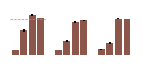

In [65]:
cm = 1/2.54
fig, ax = plt.subplots(1, 3, figsize=(4*cm, 1.5*cm))
for i in range(3):
    mean = np.nanmean(average_n_nodes_by_stage, 1)[i]
    sem = np.nanstd(average_n_nodes_by_stage, 1)[i]/np.sqrt(8)
    ax[i].bar(x=list(range(4)), height=mean, yerr=sem, color='#8C564B')
    ax[i].set_ylim([0,10])
    ax[i].set_yticks([1, 8])
    ax[i].axis('off')
ax[0].axhline(y=8, linestyle='--', linewidth=0.5, color=('0.6'))
#fig.savefig('figs/n_nodes_by_stage.pdf')

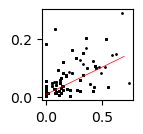

In [39]:
### --- Stage 4 Loss-Dyn Correlations --- ###

losses = []
ddyns = []
for signal_key in signal_keys_ordered:
    t_3 = dict_of_t_stage_transitions[signal_key][-1]
    loss, d_dyn = signals['test_loss'][t_3:-1], signals['aligned_graph_distances'][t_3:]
    losses = np.concatenate([losses, loss])
    ddyns = np.concatenate([ddyns, d_dyn])
model = LinearRegression()
model.fit(ddyns.reshape(-1, 1), losses)
x = np.arange(0, 0.8, 0.1)
cm = 1/2.54
fig = plt.figure(figsize=(3*cm, 3*cm))
plt.plot(ddyns, losses, '.', color='k', markersize=2)
plt.plot(x, x*model.coef_ + model.intercept_, color='r', linewidth=0.5)
#fig.savefig('figs/stage_4_loss_dyn_corr.pdf')

In [ ]:
i_analysis = 20
for i_analysis in [i_analysis]:
    key = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[key]['indices']
    fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                       key_restriction=['aligned_graph_distances', 'test_loss'],
                       stage_assignments=dict_of_stage_assignments[key])
    for t in dict_of_t_stage_transitions[key]:
        if t is not None:
            plt.axvline(indices[t], color='k', linestyle='--')
    plt.title(key)
    #fig.savefig('figs/examples/ex_{}.png'.format(i_analysis), dpi=200)

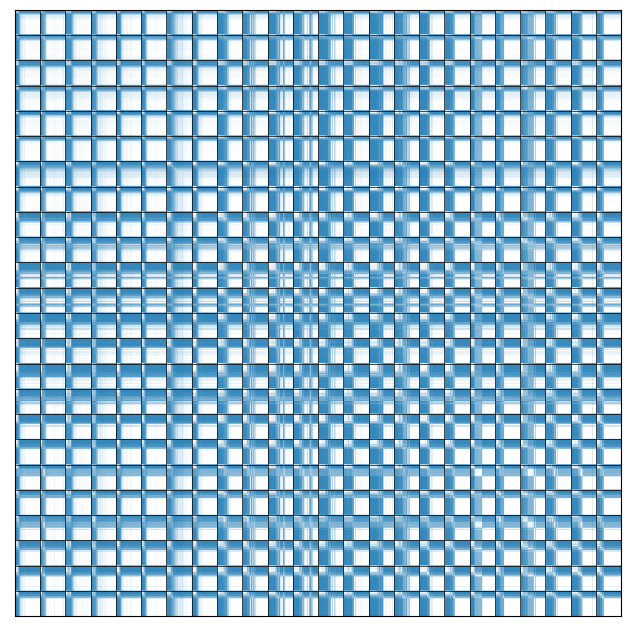

In [22]:
### --- GENERATE FULL CROSS-MATRIX --- ###

#Define basic constants for results arithmetic
algs = ['BPTT', 'DNI', 'RFLO']
n_algs = len(algs)
n_seeds = 8
n_checkpoints = 500
n_checkpoints_per_alg = n_seeds * n_checkpoints
n_total_checkpoints = n_algs * n_checkpoints_per_alg

#Extract distance matrix and symmetrize
M = result['aligned_graph_distances']
M = M + M.T

#Create figure and plot
cm = 1/2.54
fig = plt.figure(figsize=(20*cm, 20*cm))
#Colormap goes from white (smallest) to d_top blue (largest)
cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#0B6FAD'])
#cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#3FA9F5'])
#plt.imshow(M, cmap=cmap)
plt.imshow(np.roll(np.roll(M, n_checkpoints_per_alg, axis=0), n_checkpoints_per_alg, axis=1), cmap=cmap)

#Black lines to divide individual networks
for i_sim, i in enumerate(range(0, n_total_checkpoints, n_checkpoints)):
    plt.axhline(y=i, color='k', linewidth=0.5)
    plt.axvline(x=i, color='k', linewidth=0.5)
#Red lines to divide algorithms
#plt.axhline(y=n_total_checkpoints*2/3, color='C3', linewidth=0.5)
#plt.axvline(x=n_total_checkpoints*2/3, color='C3', linewidth=0.5)
#plt.axhline(y=n_total_checkpoints/3, color='C3', linewidth=0.8)
#plt.axvline(x=n_total_checkpoints/3, color='C3', linewidth=0.8)
#Identify algorithms as ticks
#plt.xticks([n_checkpoints_per_alg/2, n_checkpoints_per_alg*3/2, n_checkpoints_per_alg*5/2], algs)
#plt.yticks([n_checkpoints_per_alg/2, n_checkpoints_per_alg*3/2, n_checkpoints_per_alg*5/2], algs)
plt.xticks([])
plt.yticks([])
#plt.colorbar()

figs_path = 'figs'
fig_name = 'FigS3_Full_Cross_Matrix_reordered.png'
fig.savefig(os.path.join(figs_path, fig_name), dpi=1000, format='png')

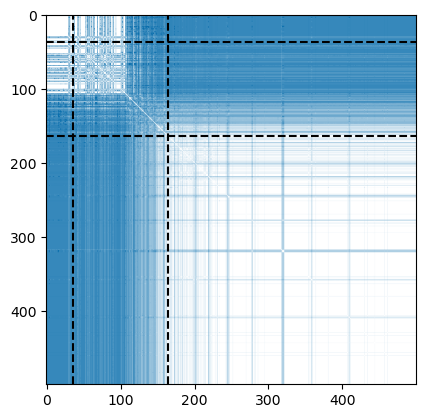

In [18]:
### --- ISOLATE INDIVIDUAL NETWORKS --- ###

#Define basic constants for results arithmetic
algs = ['BPTT', 'DNI', 'RFLO']
n_algs = len(algs)
n_seeds = 8
n_checkpoints = 500
n_checkpoints_per_alg = n_seeds * n_checkpoints
n_total_checkpoints = n_algs * n_checkpoints_per_alg

#Select networks (out of 24)
i_network = 18
j_network = 18

M = result['aligned_graph_distances']
M = M + M.T
submatrix = M[i_network*n_checkpoints:(i_network+1)*n_checkpoints,
              j_network*n_checkpoints:(j_network+1)*n_checkpoints]
fig = plt.figure()
#Colormap goes from white (smallest) to d_top blue (largest)
cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#0B6FAD'])
plt.imshow(submatrix, cmap=cmap)

#Add in lines for stage transitions
for t in dict_of_t_stage_transitions[signal_keys_ordered[i_network]]:
    if t is not None:
        plt.axvline(x=t, color='k', linestyle='--')
    else:
        pass
for t in dict_of_t_stage_transitions[signal_keys_ordered[j_network]]:
    if t is not None:
        plt.axhline(y=t, color='k', linestyle='--')
    else:
        pass

In [19]:
### --- Cross stage analysis --- ###
base_string = 'analyze_Fig_3_4_Algorithm_Variations_Result_2_seed={}_learn_alg={}'
M = result['aligned_graph_distances']
M = M + M.T
algs = ['BPTT', 'DNI', 'RFLO']
cpj = 500 #checkpoints per job
n_jobs = 24
n_seeds = 8
n_stages = 3
stage_avg_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
stage_std_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
for i_seed in range(n_seeds):
    for i_alg, alg_1 in enumerate(algs):
        i = i_alg * n_seeds + i_seed
        for j_seed in range(n_seeds):
            for j_alg, alg_2 in enumerate(algs):
                j = j_alg * n_seeds + j_seed
                
                i_job_key = base_string.format(i_seed, alg_1)
                j_job_key = base_string.format(j_seed, alg_2)                
                i_sa = dict_of_stage_assignments[i_job_key]
                j_sa = dict_of_stage_assignments[j_job_key]
                
                submatrix = M[i * cpj:(i+1) * cpj,
                              j * cpj:(j+1) * cpj]
             
                for i_stage_idx, i_stage in enumerate(range(n_stages)):
                    for j_stage_idx, j_stage in enumerate(range(n_stages)):
                        
                        i_idx = np.where(i_sa == i_stage + 1)[0]
                        j_idx = np.where(j_sa == j_stage + 1)[0]
                        
                        stage_matrix = submatrix[i_idx, :][:, j_idx]
                        if stage_matrix.size > 0:
                            mean = stage_matrix.mean()
                            std = stage_matrix.std()
                        else:
                            mean = np.nan
                            std = np.nan
                        stage_avg_array[i, j, i_stage_idx, j_stage_idx] = mean
                        stage_std_array[i, j, i_stage_idx, j_stage_idx] = std

In [ ]:
for i, i_alg in enumerate(['bptt', 'dni', 'rflo']):
    for j, j_alg in enumerate(['bptt', 'dni', 'rflo']):
        #if i_alg != 'dni' or j_alg != 'dni':
        #    continue
        fig = plt.figure()
        color = '#0B6FAD'
        plt.imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=cmap,
                   vmin=0, vmax=1.0)
        plt.axis('off')
        plt.colorbar()
        figs_path = '../../figs/frf_talk/'
        fig_name = '{}_{}_comp'.format(i_alg, j_alg)
        #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [ ]:
cm = 1/2.54
fig, ax = plt.subplots(3, 3, figsize=(4*cm, 4*cm))
for i in [2, 0, 1]:
    for j in [2, 0, 1]:
        color = '#0B6FAD'
        ax[i,j].imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=cmap,
                   vmin=0, vmax=1.0)
        ax[i,j].axis('off')
        #plt.colorbar()
figs_path = 'figs'
fig.savefig(os.path.join(figs_path, 'alg_comp.pdf'), format='pdf')

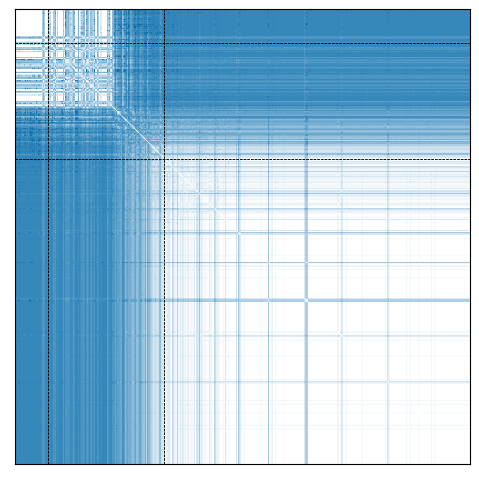

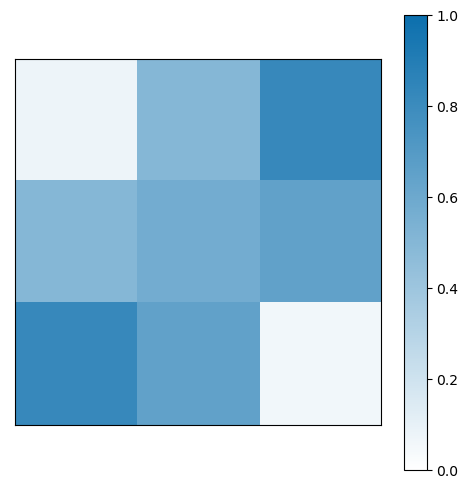

In [21]:
cm = 1/2.54
fig = plt.figure(figsize=(15*cm, 15*cm))
i_sim = 18
cpj = 500
plt.imshow(M[cpj*i_sim:cpj*(i_sim+1), cpj*i_sim:cpj*(i_sim+1)], cmap=cmap, vmin=0, vmax=1)
for t in dict_of_t_stage_transitions[signal_keys_ordered[i_sim]]:
    if t is not None:
        plt.axvline(x=t, color='k', linestyle='--', linewidth=0.5)
        plt.axhline(y=t, color='k', linestyle='--', linewidth=0.5)
    else:
        pass
    plt.axvline(x=t, color='k', linestyle='--', linewidth=0.5)
    plt.axhline(y=t, color='k', linestyle='--', linewidth=0.5)
#plt.axis('off')

plt.xticks([])
plt.yticks([])
figs_path = 'figs'
fig_name = 'sim_{}_stage_cut'.format(i_sim)
#fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

fig = plt.figure(figsize=(15*cm, 15*cm))
plt.imshow(stage_avg_array[i_sim, i_sim], cmap=cmap, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.colorbar()
#plt.axis('off')
figs_path = 'figs'
fig_name = 'sim_{}_stage_avg_colorbar'.format(i_sim)
fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [23]:
### --- Cross stage analysis random stages --- ###

### --- ASSIGN TIME POINTS TO STAGES --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_random_stage_assignments = {}
dict_of_random_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    t_stage_transitions = sorted(list(np.random.choice(range(cpj), 2, replace=False)))
    stage_assignments = np.zeros(cpj)
    stage_assignments[:t_stage_transitions[0]] = 1
    stage_assignments[t_stage_transitions[0]:t_stage_transitions[1]] = 2
    stage_assignments[t_stage_transitions[1]:] = 3
    dict_of_random_stage_assignments[signal_key] = stage_assignments
    dict_of_random_t_stage_transitions[signal_key] = t_stage_transitions

base_string = 'analyze_Fig_3_4_Algorithm_Variations_Result_2_seed={}_learn_alg={}'
M = result['aligned_graph_distances']
M = M + M.T
algs = ['BPTT', 'DNI', 'RFLO']
cpj = 500 #checkpoints per job
n_jobs = 24
n_seeds = 8
n_stages = 3
stage_avg_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
stage_std_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
for i_seed in range(n_seeds):
    for i_alg, alg_1 in enumerate(algs):
        i = i_alg * n_seeds + i_seed
        for j_seed in range(n_seeds):
            for j_alg, alg_2 in enumerate(algs):
                j = j_alg * n_seeds + j_seed
                
                i_job_key = base_string.format(i_seed, alg_1)
                j_job_key = base_string.format(j_seed, alg_2)                
                i_sa = dict_of_random_stage_assignments[i_job_key]
                j_sa = dict_of_random_stage_assignments[j_job_key]
                
                submatrix = M[i * cpj:(i+1) * cpj,
                              j * cpj:(j+1) * cpj]
             
                for i_stage_idx, i_stage in enumerate(range(n_stages)):
                    for j_stage_idx, j_stage in enumerate(range(n_stages)):
                        
                        i_idx = np.where(i_sa == i_stage + 1)[0]
                        j_idx = np.where(j_sa == j_stage + 1)[0]
                        
                        stage_matrix = submatrix[i_idx, :][:, j_idx]
                        if stage_matrix.size > 0:
                            mean = stage_matrix.mean()
                            std = stage_matrix.std()
                        else:
                            mean = np.nan
                            std = np.nan
                        stage_avg_array[i, j, i_stage_idx, j_stage_idx] = mean
                        stage_std_array[i, j, i_stage_idx, j_stage_idx] = std

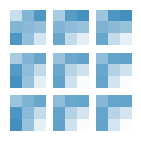

In [24]:
cm = 1/2.54
fig, ax = plt.subplots(3, 3, figsize=(4*cm, 4*cm))
for i in [2, 0, 1]:
    for j in [2, 0, 1]:
        color = '#0B6FAD'
        ax[i,j].imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=cmap,
                   vmin=0, vmax=1.0)
        ax[i,j].axis('off')
        #plt.colorbar()
figs_path = 'figs'
#fig.savefig(os.path.join(figs_path, 'alg_comp_random_control.pdf'), format='pdf')

In [45]:
### --- Cross stage analysis loss-based stages --- ###

### --- ASSIGN TIME POINTS TO STAGES --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_loss_based_stage_assignments = {}
dict_of_loss_based_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_3_stages_control(loss, 0.5, 0.05,
                                                                                    loss_window=50)
    dict_of_loss_based_stage_assignments[signal_key] = stage_assignments
    dict_of_loss_based_t_stage_transitions[signal_key] = t_stage_transitions

base_string = 'analyze_Fig_3_4_Algorithm_Variations_Result_2_seed={}_learn_alg={}'
M = result['aligned_graph_distances']
M = M + M.T
algs = ['BPTT', 'DNI', 'RFLO']
cpj = 500 #checkpoints per job
n_jobs = 24
n_seeds = 8
n_stages = 3
stage_avg_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
stage_std_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
for i_seed in range(n_seeds):
    for i_alg, alg_1 in enumerate(algs):
        i = i_alg * n_seeds + i_seed
        for j_seed in range(n_seeds):
            for j_alg, alg_2 in enumerate(algs):
                j = j_alg * n_seeds + j_seed
                
                i_job_key = base_string.format(i_seed, alg_1)
                j_job_key = base_string.format(j_seed, alg_2)                
                i_sa = dict_of_loss_based_stage_assignments[i_job_key]
                j_sa = dict_of_loss_based_stage_assignments[j_job_key]
                
                submatrix = M[i * cpj:(i+1) * cpj,
                              j * cpj:(j+1) * cpj]
             
                for i_stage_idx, i_stage in enumerate(range(n_stages)):
                    for j_stage_idx, j_stage in enumerate(range(n_stages)):
                        
                        i_idx = np.where(i_sa == i_stage + 1)[0]
                        j_idx = np.where(j_sa == j_stage + 1)[0]
                        
                        stage_matrix = submatrix[i_idx, :][:, j_idx]
                        if stage_matrix.size > 0:
                            mean = stage_matrix.mean()
                            std = stage_matrix.std()
                        else:
                            mean = np.nan
                            std = np.nan
                        stage_avg_array[i, j, i_stage_idx, j_stage_idx] = mean
                        stage_std_array[i, j, i_stage_idx, j_stage_idx] = std

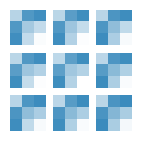

In [62]:
cm = 1/2.54
fig, ax = plt.subplots(3, 3, figsize=(4*cm, 4*cm))
for i in [2, 0, 1]:
    for j in [2, 0, 1]:
        color = '#0B6FAD'
        cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#0B6FAD'])
        ax[i,j].imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=cmap,
                   vmin=0, vmax=1.0)
        ax[i,j].axis('off')
        #plt.colorbar()
figs_path = 'figs'
fig.savefig(os.path.join(figs_path, 'alg_comp_test_loss_control.pdf'), format='pdf')

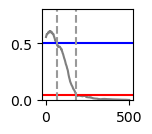

In [63]:
### --- FIGURE S3 LOSS BASED EXAMPLE --- ###
signal_key = signal_keys_ordered[19]
signals = signal_dicts[signal_key]
loss = signals['test_loss']
#Reflect test loss over 0 time point for causal convolution
loss_window = 50
loss_kernel = np.ones(loss_window) / loss_window
reflected_loss = np.concatenate([loss[loss_window - 1:0:-1], loss])
convolved_loss = np.convolve(reflected_loss, loss_kernel, mode='valid')
cm = 1/2.54
fig = plt.figure(figsize=(3*cm, 3*cm))
plt.plot(convolved_loss, color='#7F7F7F')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.axvline(x=65, color=('0.6'), linestyle='--')
plt.axvline(x=180, color=('0.6'), linestyle='--')
plt.ylim([0, 0.8])
fig.savefig('figs/test_loss_crit.pdf')

In [ ]:
### --- FIGURE 2B CHANGES IN D_SYN AND L BY STAGE --- ###

## -- SYNAPTIC CHANGES -- ##

d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    d_syn = signals['rec_weight_distances']
    d_syn_vals = [d_syn[np.where(SA == i_stage)[0]] for i_stage in range(1, 5)]
    d_syn_stage_mean = [np.mean(l) if len(l)>0 else np.nan for l in d_syn_vals]
    d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], np.nanmean(d_syn_stage_means, 0), color='#3A0882')
plt.axis('off')
#fig.savefig('figs/fig2b_dsyn.pdf', dpi=300, format='pdf')

## -- LOSS CHANGES -- ##

d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    loss = signals['test_loss']
    d_loss = loss[1:] - loss[:-1]
    loss_vals = [d_loss[np.where(SA == i_stage)[0]] for i_stage in range(1, 5)]
    d_loss_stage_mean = [np.mean(l) if len(l)>0 else np.nan for l in loss_vals]
    d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], -np.nanmean(d_loss_stage_means, 0), color='#7F7F7F')
plt.axis('off')
#fig.savefig('figs/fig2b_dloss.pdf', dpi=300, format='pdf')

In [ ]:
plt.imshow(-d_loss_stage_means)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('owen', [('1'), '#3FA9F5'])
geo_cmap = LinearSegmentedColormap.from_list('geo', [('1'), '#1A8E48'])

In [ ]:
dict_of_t_stage_transitions

In [ ]:
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    filtered_loss, filtered_d_top = filter_loss_and_dtop(loss, d_top,
                                                         topological_window=10, loss_window=50)
    #plt.plot(filtered_loss, color=('0.5'))
    plt.plot(uniform_filter1d(loss, size=50), color='k')

In [ ]:
from scipy.stats import pearsonr, spearmanr

filters = [1, 3, 10, 30, 50, 100]
#filters = [10]
coefs = np.zeros((len(filters), len(filters)))
p_values = np.zeros_like(coefs)
for i, t_dyn_filter in enumerate(filters):
    for j, t_loss_filter in enumerate(filters):
        signal_keys_ordered = sorted(signal_dicts.keys())
        d_dyn_all = np.array([])
        d_loss_all = np.array([])
        for i_key, key in enumerate(signal_keys_ordered):
            if 'DNI' not in key:
                continue
            signals = signal_dicts[key]
            d_dyn = uniform_filter1d(signals['aligned_graph_distances'], size=t_dyn_filter)
            d_dyn_all = np.concatenate([d_dyn_all, d_dyn])
            loss = uniform_filter1d(signals['test_loss'], size=t_loss_filter)
            d_loss = loss[1:] - loss[:-1]
            d_loss_all = np.concatenate([d_loss_all, d_loss])
            plt.plot(d_dyn, d_loss, '.', color='C0', alpha=0.1)
            ccoef = pearsonr(d_dyn_all, d_loss_all)
            coefs[i,j] = ccoef.statistic
            p_values[i,j] = ccoef.pvalue
        #plt.xlim([0, 0.2])
        #plt.ylim([-0.02, 0.02])
        #plt.yscale('log')
from scipy.stats import pearsonr, spearmanr
ccoef = spearmanr(d_dyn_all, d_loss_all)

In [ ]:
algs = ['BPTT', 'RFLO', 'DNI']
fig, ax = plt.subplots(3, 1, figsize=(4, 6))
avg_loss_traces = {alg:0 for alg in algs}
avg_d_dyn_traces = {alg:0 for alg in algs}
for i_key, key in enumerate(signal_dicts):
    i_alg = algs.index(key.split('learn_alg=')[-1])
    loss = signal_dicts[key]['test_loss']
    d_dyn = signal_dicts[key]['aligned_graph_distances']
    d_syn = signal_dicts[key]['rec_weight_distances']
    n_nodes = signal_dicts[key]['n_nodes']
    avg_loss_traces[algs[i_alg]] += loss
    avg_d_dyn_traces[algs[i_alg]] += d_dyn
    ax[i_alg].plot(uniform_filter1d(d_dyn, size=50), color='C0', alpha=0.4)
    #ax[i_alg].plot(uniform_filter1d(d_syn, size=50), color='#3A0882', alpha=0.4)
    ax[i_alg].plot(uniform_filter1d(loss, size=50), color='k', alpha=0.4)
    #ax[i_alg].plot(uniform_filter1d(n_nodes/8, size=50), color='C6', alpha=0.4)

In [ ]:
cm = 1/2.54
fig, ax = plt.subplots(3, 1, figsize=(3*cm, 4*cm))
for i_alg, alg in enumerate(algs):
    ax[i_alg].plot(avg_loss_traces[alg]/8, linewidth=0.3, color='#7F7F7F')
    ax[i_alg].plot(avg_d_dyn_traces[alg]/8, linewidth=0.3, color='#3FA9F5')
    ax[i_alg].set_ylim([-0.05, 1])
    ax[i_alg].axis('off')
fig.savefig('figs/alg_averages.pdf')